# Assignment 2
## Scale-space blob detection
### Emmanuel Gallegos
### CS 543 - Computer Vision
### UIUC
### 9/24/2022

In [1]:
# imports
import os
import time
import numpy as np
import scipy
import skimage
from PIL import Image
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_laplace
from matplotlib.patches import Circle

In [2]:
# set image paths
img_dir = os.path.join(os.getcwd(), "part2_images")
img_paths = [os.path.join(img_dir, img_path) for img_path in os.listdir(img_dir)]
# make directory for blob detection photos if it does not exist
blob_dir_1 = os.path.join(os.getcwd(), "part2_blob_images_method_1")
blob_dir_2 = os.path.join(os.getcwd(), "part2_blob_images_method_2")
if not os.path.exists(blob_dir_1):
    os.mkdir(blob_dir_1)
if not os.path.exists(blob_dir_2):
    os.mkdir(blob_dir_2)
blobbed_paths_1 = [os.path.join(blob_dir_1, img_path) for img_path in os.listdir(img_dir)]
blobbed_paths_2 = [os.path.join(blob_dir_2, img_path) for img_path in os.listdir(img_dir)]
print(img_paths)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(blobbed_paths_1)
print(blobbed_paths_2)

In [3]:
#constants
INIT_SCALE = 2
k = 1.5
NUM_LEVELS = 10
NMS_FILTER_DIM = 15
NMS_FILTER_DEPTH = 5
NMS_2D_FILTER_SIZE = (NMS_FILTER_DIM, NMS_FILTER_DIM)
NMS_3D_FILTER_SIZE = (NMS_FILTER_DIM, NMS_FILTER_DIM, NMS_FILTER_DEPTH) 
THRESHOLD = 0.012
THRESHOLD_2 = 0.0005

In [4]:
# To display the detected regions as circle
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()
    
def my_nms_filter(a):
    return np.max(a) if a[len(a)//2] == np.max(a) else 0

## Increasing filter size

Blobbing time: 19.771998643875122


<Figure size 2304x2304 with 0 Axes>

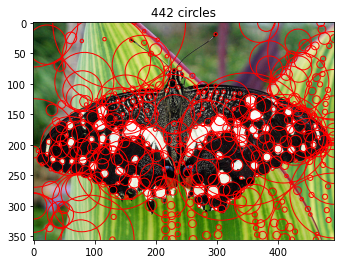

Blobbing time: 34.65901160240173


<Figure size 2304x2304 with 0 Axes>

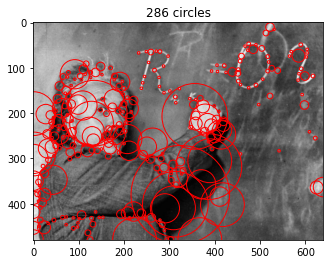

Blobbing time: 19.22601890563965


<Figure size 2304x2304 with 0 Axes>

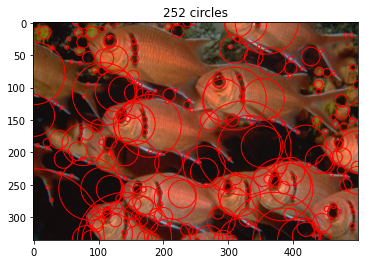

Blobbing time: 25.22001075744629


<Figure size 2304x2304 with 0 Axes>

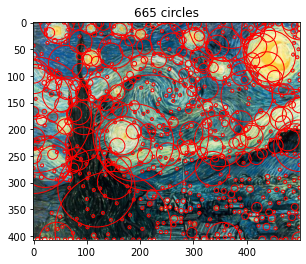

Blobbing time: 15.809639692306519


<Figure size 2304x2304 with 0 Axes>

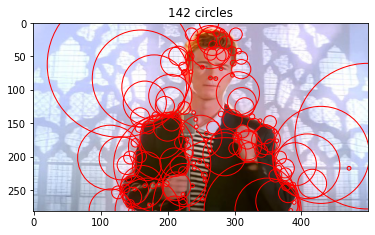

Blobbing time: 31.2648503780365


<Figure size 2304x2304 with 0 Axes>

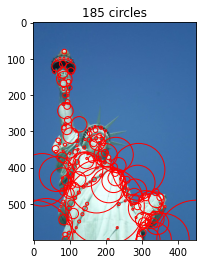

Blobbing time: 30.847683668136597


<Figure size 2304x2304 with 0 Axes>

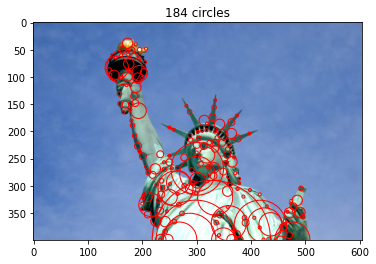

Blobbing time: 13.064004182815552


<Figure size 2304x2304 with 0 Axes>

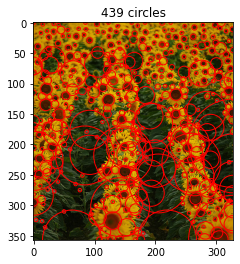

In [5]:
for n in range(len(img_paths)):
    image = Image.open(img_paths[n])
    # convert images to grayscale
    grayscale_img = image.convert("L")
    np_img = np.array(grayscale_img)
    # rescale the intensities to between 0 and 1 (simply divide them by 255 should do the trick)
    rescaled_img = np_img / 255
    
    fig = plt.figure(figsize=(32, 32))
    rows = NUM_LEVELS
    columns = 1
    
    # filtering by increasing filter size
    img_shape = rescaled_img.shape
    # [h,w] - dimensions of image, n - number of levels in scale space
    scale_space = np.empty((img_shape[0],img_shape[1], NUM_LEVELS)) 
    
    # timing
    start_time = time.time()
    
    for i in range(NUM_LEVELS):
        sigma = INIT_SCALE * (k ** i)
        scale_space[:,:,i] = gaussian_laplace(rescaled_img, sigma)
        # scale normalization
        scale_space[:,:,i] *= (sigma ** 2)    
        # square laplacian response
        scale_space[:,:,i] **= 2
        # non-max suppression in 2d slices of scale space
        scale_space[:,:,i] = scipy.ndimage.generic_filter(scale_space[:,:,i], my_nms_filter, size=NMS_2D_FILTER_SIZE)
        
    # non-max suppression in 3d scale space
    scale_space = scipy.ndimage.generic_filter(scale_space, my_nms_filter, size=NMS_3D_FILTER_SIZE)
    
    # thresholding
    indices = np.argwhere(scale_space > THRESHOLD)
    
    # timing
    end_time = time.time()
    total_time = end_time - start_time
    
    print("Blobbing time: " + str(total_time))
    
    cx = []
    cy = []
    rad = []

    for j in range(len(indices)):
        cy.append(indices[j][0])
        cx.append(indices[j][1])
        rad.append(INIT_SCALE * (2 ** 0.5) * (k ** indices[j][2]))

    show_all_circles(image, cx, cy, rad)

## Downsampling

(356, 493, 10)
Blobbing time: 19.210033893585205


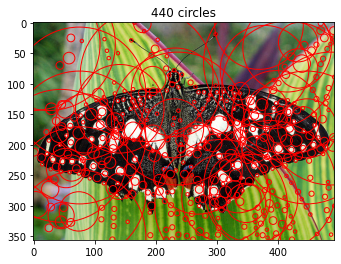

(480, 640, 10)
Blobbing time: 34.32812738418579


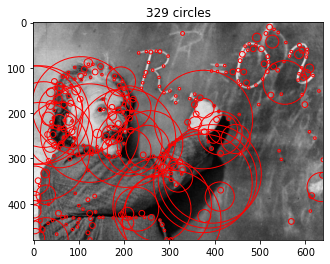

(335, 500, 10)
Blobbing time: 18.828007459640503


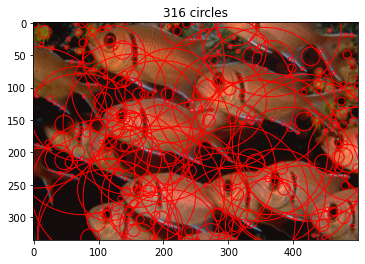

(408, 500, 10)
Blobbing time: 22.70610737800598


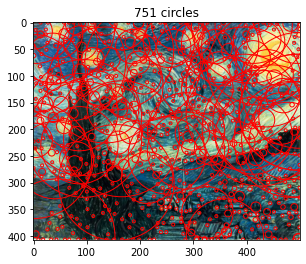

(281, 500, 10)
Blobbing time: 15.405540943145752


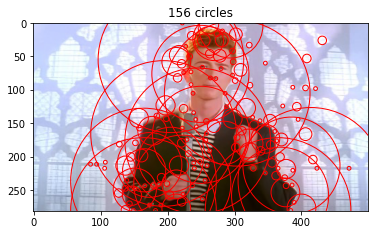

(600, 450, 10)
Blobbing time: 30.341142654418945


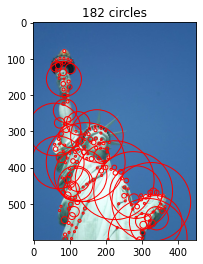

(400, 604, 10)
Blobbing time: 26.814117193222046


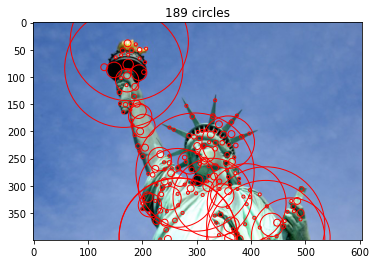

(357, 328, 10)
Blobbing time: 12.840094089508057


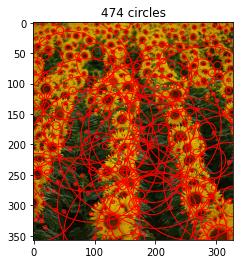

In [6]:
for image_path in img_paths:
    image = Image.open(image_path)
    # convert images to grayscale
    grayscale_img = image.convert("L")
    np_img = np.array(grayscale_img)
    # rescale the intensities to between 0 and 1 (simply divide them by 255 should do the trick)
    rescaled_img = np_img / 255
    # save shape
    img_shape = rescaled_img.shape
    
    # filtering by downsampling
    scale_space = np.empty(NUM_LEVELS, dtype=object) # creates an object array with n "slots"
    
    # make image pyramid
    image_pyramid = [skimage.transform.resize(rescaled_img, (int(img_shape[0] / k), int(img_shape[1] / k))) for k in range(1,NUM_LEVELS+1)]
    
    # timing
    start_time = time.time()
    
    for i in range(NUM_LEVELS):
        sigma = INIT_SCALE * (k ** i)
        # using one scale for all levels
        scale_space[i] = gaussian_laplace(image_pyramid[i], INIT_SCALE)
        
        # scale normalization (since we are upsampling)
        #scale_space[i] *= (sigma ** 2)       
        # square laplacian response
        scale_space[i] **= 2
        
        # upsample back to full size
        scale_space[i] = skimage.transform.resize(scale_space[i], img_shape)
        
        # non-max suppression in 2d slices of scale space
        scale_space[i] = scipy.ndimage.generic_filter(scale_space[i], my_nms_filter, size=NMS_2D_FILTER_SIZE)
    
    # convert back to numpy array
    np_pyramid = np.array([np.array(pyr_level) for pyr_level in scale_space])
    # reshape to n_rows, n_cols, NUM_LEVELS
    np_pyramid = np_pyramid.transpose(1,2,0)
    print(np_pyramid.shape)
    
    # non-max suppression in 3d scale space
    scale_space = scipy.ndimage.generic_filter(np_pyramid, my_nms_filter, size=NMS_3D_FILTER_SIZE)
    
    # thresholding
    indices = np.argwhere(scale_space > THRESHOLD_2)
    
    # timing
    end_time = time.time()
    total_time = end_time - start_time
    
    print("Blobbing time: " + str(total_time))
    
    cx = []
    cy = []
    rad = []

    for j in range(len(indices)):
        cy.append(indices[j][0])
        cx.append(indices[j][1])
        rad.append(INIT_SCALE * (2 ** 0.5) * (k ** indices[j][2]))

    show_all_circles(image, cx, cy, rad)